In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA

from google.colab import drive
drive.mount("/content/drive")

base_path = '/content/drive/MyDrive/data/'  # <-- Make sure this folder exists and contains the TSV files
papers_tsv = base_path + 'Papers_CS_20190919.tsv'
authors_tsv = base_path + 'PAuAf_CS_20190919.tsv'
citations_tsv = base_path + 'PR_CS_20190919.tsv'

print("=== Step 1: Loading the TSV files ===")
papers_df = pd.read_csv(papers_tsv, sep="\t")
papers_df.dropna(inplace=True)
papers_df.reset_index(drop=True, inplace=True)

authors_df = pd.read_csv(authors_tsv , sep="\t")
authors_df.dropna(inplace=True)
authors_df.reset_index(drop=True, inplace=True)

citations_df = pd.read_csv(citations_tsv, sep="\t")
citations_df.dropna(inplace=True)
citations_df.reset_index(drop=True, inplace=True)

print("Loaded datasets.")
print(papers_df.head())
print(authors_df.head())
print(citations_df.head())

Mounted at /content/drive
=== Step 1: Loading the TSV files ===
Loaded datasets.
      PaperId  PublishYear                                    NormalizedTitle  \
0  2162250601         2011                          visual object recognition   
1  2912118192         2019        learning and decision making from rank data   
2    50703724         2007  preparing future secondary computer science ed...   
3   250824747         2002  demonstrating the potential for web based surv...   
4   130379505         1998             creating a performance based classroom   

      VenueId DetectedLanguage  DocType  EstimatedCitation  
0   933803995     en@@@fa@@@ja  Journal                178  
1   933803995               en  Journal                  0  
2  2764343864               en  Journal                  2  
3  2764343864               en  Journal                 92  
4  2764343864               en  Journal                  0  
   PaperSeqid  AuthorSeqid  AffiliationSeqid  AuthorSequenceNumber

In [2]:
print("\n=== Step 2: Preprocessing citation counts ===")
citation_count = defaultdict(int)
for ref_id in citations_df["ReferenceId"]:
    citation_count[ref_id] += 1

print("Building paper metadata.")
paper_meta = {}
for _, row in papers_df.iterrows():
    paper_id = row["PaperId"]
    year = row["PublishYear"]
    estimated_citation = row["EstimatedCitation"]
    paper_meta[paper_id] = (year, estimated_citation, citation_count.get(paper_id, 0))

print("Metadata complete.")



=== Step 2: Preprocessing citation counts ===
Building paper metadata.
Metadata complete.


In [3]:
print("\n=== Step 3: Building author features ===")
author_stats = defaultdict(lambda: {
    "paper_count": 0,
    "total_est_citations": 0,
    "total_true_citations": 0,
    "coauthors": set(),
    "active_years": set()
})

print("Grouping paper authors.")
paper_authors = defaultdict(list)
for _, row in authors_df.iterrows():
    paper_id = row["PaperSeqid"]
    author_id = row["AuthorSeqid"]
    paper_authors[paper_id].append(author_id)

print("Calculating stats per author.")
for paper_id, authors in tqdm(paper_authors.items(), desc="Processing authors"):
    meta = paper_meta.get(paper_id)
    if not meta:
        continue
    year, est_cite, true_cite = meta
    for author in authors:
        author_stats[author]["paper_count"] += 1
        author_stats[author]["total_est_citations"] += est_cite
        author_stats[author]["total_true_citations"] += true_cite
        author_stats[author]["coauthors"].update(set(authors) - {author})
        author_stats[author]["active_years"].add(year)

print("Converting author stats to DataFrame.")
data = []
for author, stats in author_stats.items():
    data.append({
        "author_id": author,
        "paper_count": stats["paper_count"],
        "avg_est_citations": stats["total_est_citations"] / stats["paper_count"],
        "avg_true_citations": stats["total_true_citations"] / stats["paper_count"],
        "unique_coauthors": len(stats["coauthors"]),
        "active_years": len(stats["active_years"])
    })

df = pd.DataFrame(data)
print("Author DataFrame created.")


=== Step 3: Building author features ===
Grouping paper authors.
Calculating stats per author.


Processing authors: 100%|██████████| 3570851/3570851 [01:14<00:00, 48043.12it/s]


Converting author stats to DataFrame.
Author DataFrame created.


In [4]:
print("\n=== Step 4: Normalizing features ===")
features = ["paper_count", "avg_est_citations", "avg_true_citations", "unique_coauthors", "active_years"]
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features normalized.")


=== Step 4: Normalizing features ===
Features normalized.



=== Step 5: Elbow Method ===
Fitting KMeans for k = 1...
Fitting KMeans for k = 2...
Fitting KMeans for k = 3...
Fitting KMeans for k = 4...
Fitting KMeans for k = 5...
Fitting KMeans for k = 6...
Fitting KMeans for k = 7...
Fitting KMeans for k = 8...
Fitting KMeans for k = 9...
Fitting KMeans for k = 10...
Fitting KMeans for k = 11...
Fitting KMeans for k = 12...
Fitting KMeans for k = 13...
Fitting KMeans for k = 14...
Fitting KMeans for k = 15...
Fitting KMeans for k = 16...
Fitting KMeans for k = 17...
Fitting KMeans for k = 18...
Fitting KMeans for k = 19...


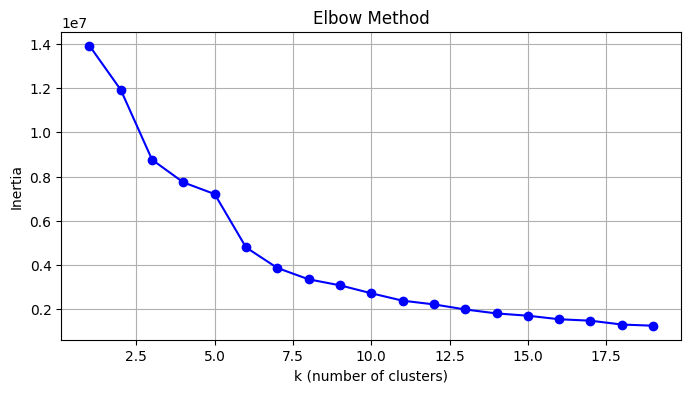

In [8]:
print("\n=== Step 5: Elbow Method ===")
inertias = []
K_range = range(1, 20)

for k in K_range:
    print(f"Fitting KMeans for k = {k}...")
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel("k (number of clusters)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.grid(True)
plt.show()

In [ ]:
print("\n=== Step 6: Final Clustering ===")
k = 7
print(f"Running KMeans with k = {k}...")
final_kmeans = KMeans(n_clusters=k, random_state=42)
df["cluster"] = final_kmeans.fit_predict(X_scaled)

print("\nSample authors with cluster labels:")
print(df[["author_id", "cluster"]].head())

print("Saving clustered data to CSV...")
df.to_csv("clustered_authors.csv", index=False)

print("\n=== Step 6.5: Evaluating with Silhouette Score (on a sample) ===")
sample_size = min(100000, len(X_scaled))  # avoid going out of bounds
X_sample = X_scaled[:sample_size]
labels_sample = df["cluster"].values[:sample_size]

score = silhouette_score(X_sample, labels_sample, metric='euclidean')
print(f"Silhouette Score (on sample of {sample_size}): {score:.4f}")


=== Step 6: Final Clustering ===
Running KMeans with k = 7...

Sample authors with cluster labels:
      author_id  cluster
0  2.167258e+09        3
1  2.506098e+09        6
2  2.296113e+09        3
3  2.951973e+09        6
4  2.308752e+09        6
Saving clustered data to CSV...

=== Step 6.5: Evaluating with Silhouette Score (on a sample) ===



=== Step 7: Visualizing Clusters with PCA ===


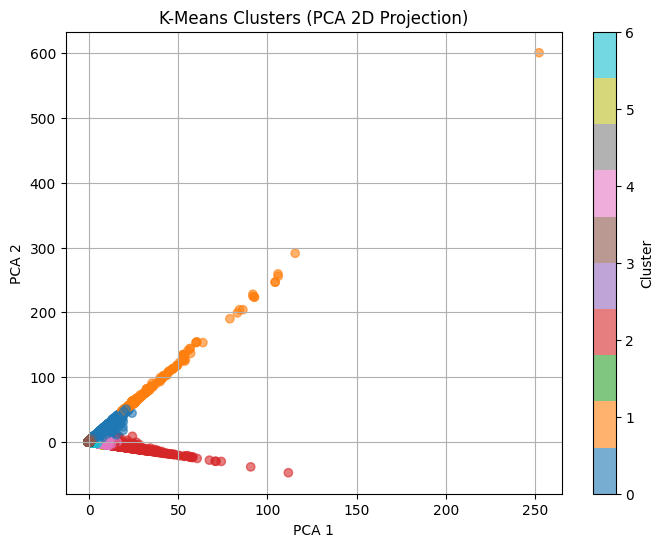

All steps complete.


In [10]:
print("\n=== Step 7: Visualizing Clusters with PCA ===")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["cluster"], cmap='tab10', alpha=0.6)
plt.title("K-Means Clusters (PCA 2D Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()

print("All steps complete.")


In [11]:
fig.savefig("pca_clusters.png", dpi=300, bbox_inches='tight')


NameError: name 'fig' is not defined